In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Marchenko - Pastur Distribution simulation to show behaviour of eigenvalues with different N/K

In [2]:
import numpy as np
import matplotlib.pyplot as plt

<ipython-input-3-59004e0507d8>:32: RuntimeWarning: invalid value encountered in true_divide
  mp = np.sqrt((b - xx)*(xx - a))/(2*np.pi*gamma*xx)*max(gamma, 1)


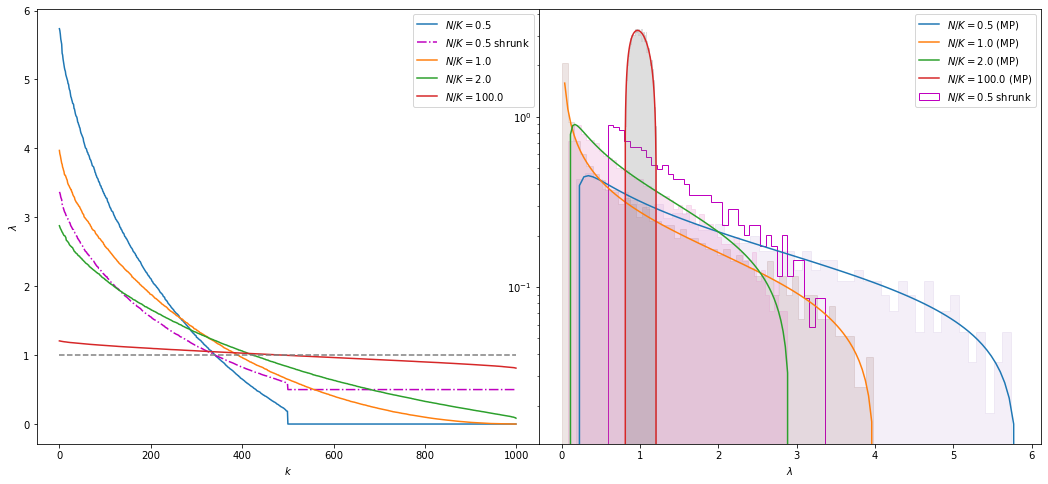

In [3]:
K = 1000
fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(8)
ax1 = fig.add_subplot(121)

shrink = 0.5
gammas = [ 2.0, 1.0, 0.5, 0.01]
labels = [f'$N/K={1/gamma}$' for gamma in gammas]
slab = labels[0] + ' shrunk'
evalues = [None for gamma in gammas]

for idx, gamma in enumerate(gammas):
    N = int(K/gamma)
    X = np.random.normal(size=(N, K))
    C = X.T@X/N # (K, K)
    evalues[idx], _ = np.linalg.eigh(C)
    ax1.plot(range(K), np.flip(evalues[idx]), label=labels[idx])

    if idx == 0 and shrink:
        shrunk, _ = np.linalg.eigh(shrink*C + (1-shrink)*np.identity(K))
        ax1.plot(range(K), np.flip(shrunk), '-.', color='m', label=slab)
        
ax1.plot(range(K), np.ones(K), '--', color='grey')
ax2 = fig.add_subplot(122)
plt.yscale('log')
    
for idx, gamma in enumerate(gammas):
    # Marchenko-Pastur theory:
    a, b = (1 - np.sqrt(gamma))**2, (1 + np.sqrt(gamma))**2
    xx = np.linspace(a, b, 100)
    mp = np.sqrt((b - xx)*(xx - a))/(2*np.pi*gamma*xx)*max(gamma, 1)
    ax2.plot(xx, mp, label=labels[idx] + ' (MP)')
for idx, gamma in enumerate(gammas):
    # histograms of eigenvalues:
    evals = evalues[idx]
    evals = evals[evals > 1e-3].reshape((-1, 1))
    ax2.hist(evals, bins=50, histtype='step', density=True,
             fill=True, alpha=0.1 + idx*0.05)
    if idx == 0 and shrink:
        # discard repeated lowest eigenvalues:
        shrunk = shrunk[shrunk > 1 - shrink + 1e-3]
        ax2.hist(shrunk, bins=40, histtype='step',
                density=True, color='m', label=slab)
    
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'$\lambda$')
ax1.legend();
ax2.set_xlabel(r'$\lambda$')
ax2.legend()
plt.subplots_adjust(wspace=0)
plt.show()

# Denoising and targeted shrinkage

In [104]:
import numpy as np
import pandas as pd
from sklearn.neighbors.kde import KernelDensity
from scipy.optimize import minimize

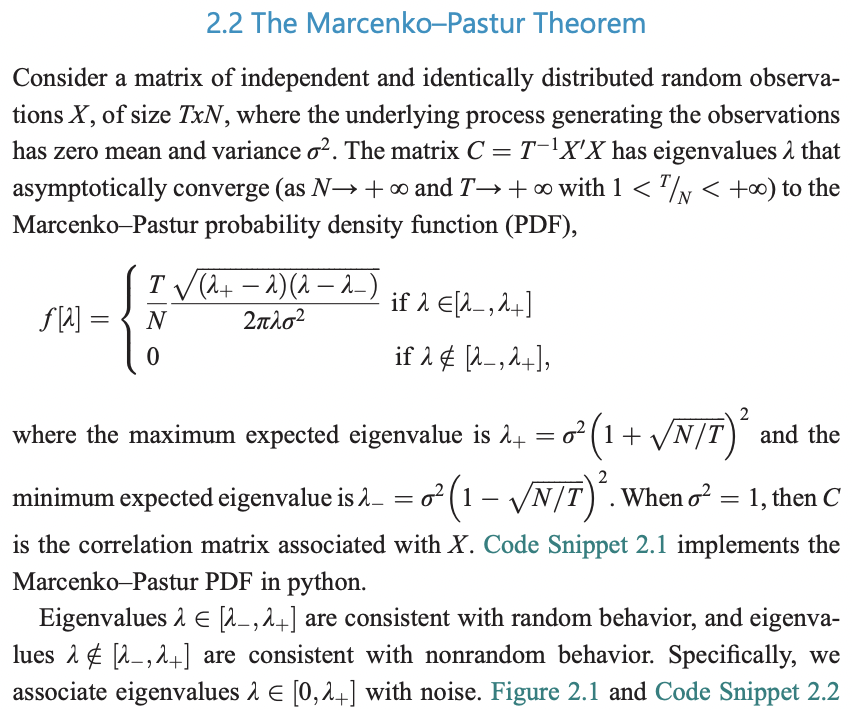

In [90]:
from IPython.display import Image
Image(filename='1.png',width=600, height=600)

In [92]:
# SNIPPET 2.1 THE MARCENKO–PASTUR PDF
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q=T/N 
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax, pts)
    if len(np.shape(eVal)) == 2:
        eVal_fixed = []
        for i in eVal:
#             print(i[0])
            eVal_fixed.append(i[0])
        eVal = eVal_fixed
            
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [45]:
# TESTING THE MARCENKO–PASTUR THEOREM
#--------------------------------------------------- 
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix 
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices] 
    eVal=np.diagflat(eVal)
    return eVal,eVec

#--------------------------------------------------- 
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated 
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1) 
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

#--------------------------------------------------- 
x=np.random.normal(size=(10000,1000)) 
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0)) 
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000) 
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf

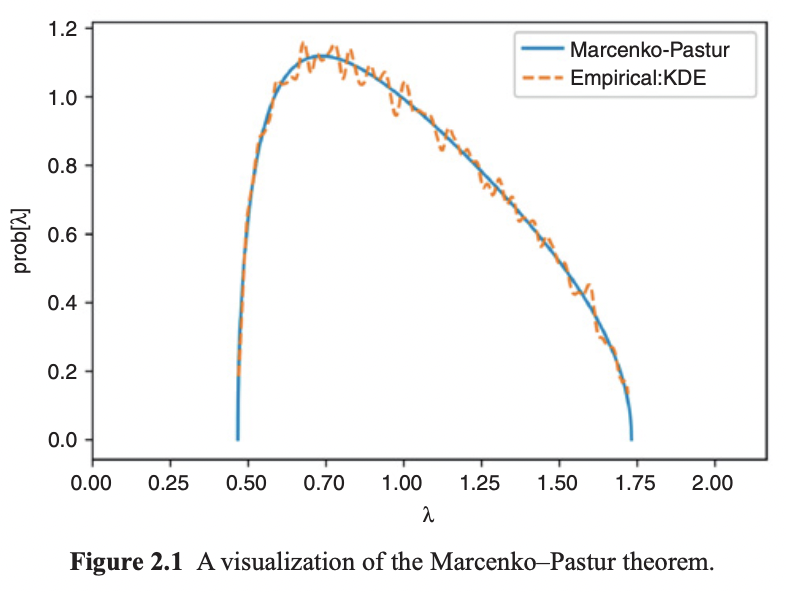

In [91]:
from IPython.display import Image
Image(filename='2.png',width=600, height=600)

In an empirical correlation matrix, not all eigenvectors may be random.

Code below builds a covariance matrix that is not perfectly random and
hence its eigenvalues will only approximately follow the Marcenko–Pastur PDF.

Out of the nCols random variables that form the covariance matrix generated by getRndCov, only nFact contain some signal. 

To further dilute the signal, we add that covariance matrix to a purely random matrix, with a weight alpha.

In [47]:
# ADD SIGNAL TO A RANDOM COVARIANCE MATRIX
def getRndCov(nCols,nFacts): 
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank 
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov 
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov)) 
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error 
    return corr


alpha,nCols,nFact,q=.995,1000,100,10
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal 
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)

Before proceed further, we need to fit MARCENKO–PASTUR distribution to the empirical distribution of eigenvalues to get sigmas which we then use to determine cutoff levels

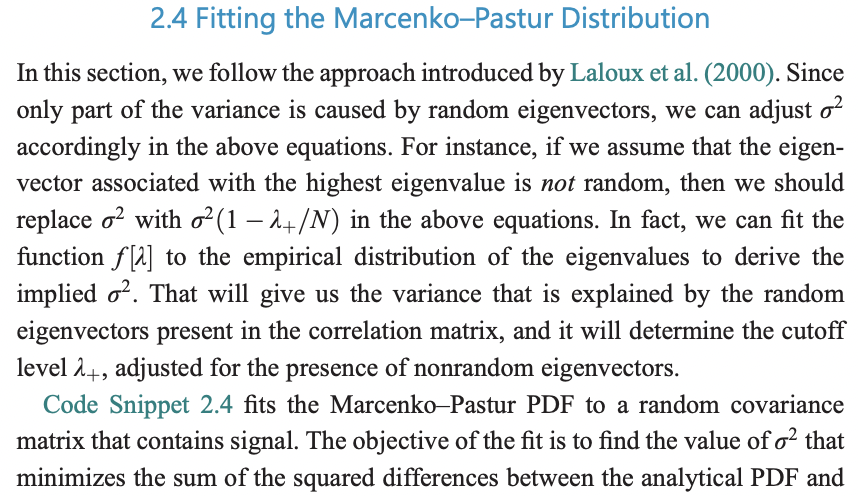

In [97]:
Image(filename='3.png',width=600, height=600)

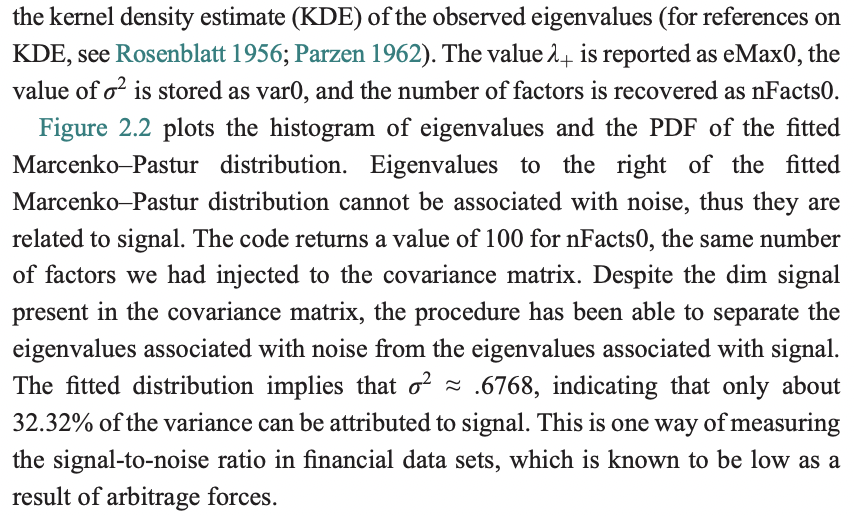

In [99]:
Image(filename='4.png',width=600, height=600)

In [101]:
# FITTING THE MARCENKO–PASTUR PDF
#--------------------------------------------------- 
def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf 
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf 
    sse=np.sum((pdf1-pdf0)**2)
    return sse

#--------------------------------------------------- 
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist 
    out=minimize(lambda *x: errPDFs(*x), .5, args=(eVal,q,bWidth), bounds=((1E-5,1-1E-5),))
    if out['success']: 
        var=out['x'][0] 
    else: var=1 
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

#--------------------------------------------------- 
eMax0,var0 = findMaxEval(np.diag(eVal0),q,bWidth=.01)

nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

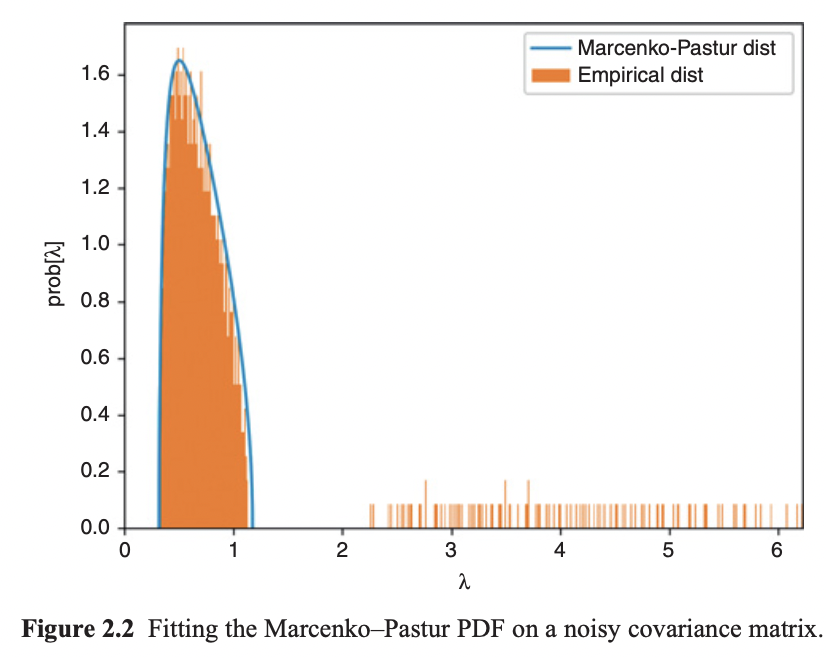

In [103]:
Image(filename='5.png',width=600, height=600)

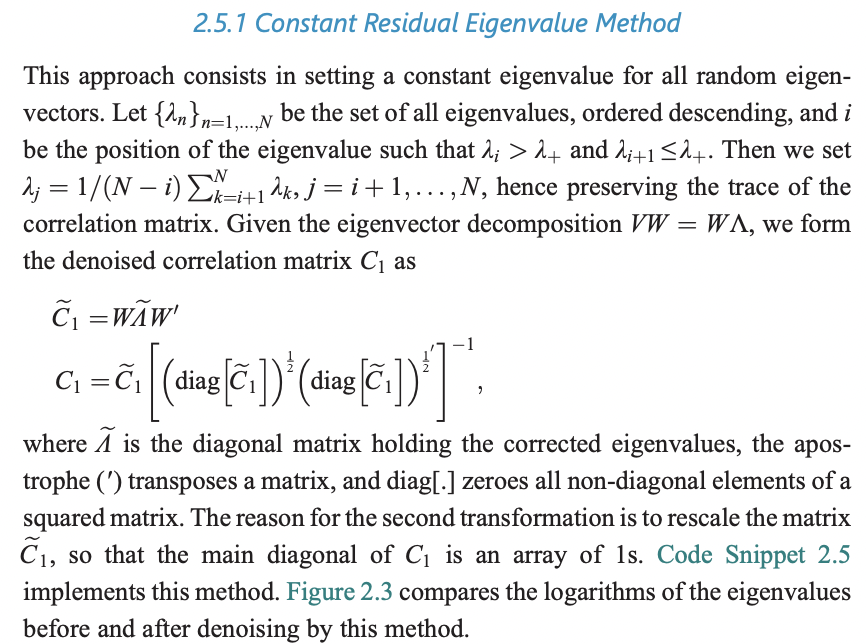

In [105]:
Image(filename='6.png',width=600, height=600)

In [52]:
# DENOISING BY CONSTANT RESIDUAL EIGENVALUE
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues 
    eVal_= np.diag(eVal).copy() 
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_= np.diag(eVal_)
    corr1 = np.dot(eVec,eVal_).dot(eVec.T) 
    corr1 = cov2corr(corr1)
    return corr1
#--------------------------------------------------- 
corr1 = denoisedCorr(eVal0, eVec0, nFacts0) 
eVal1, eVec1 = getPCA(corr1)

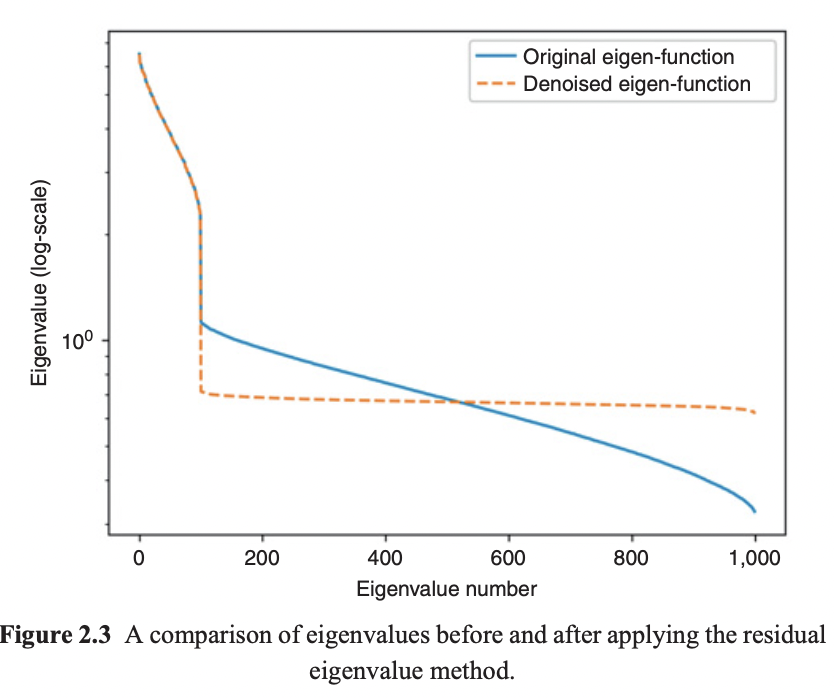

In [106]:
Image(filename='7.png',width=600, height=600)

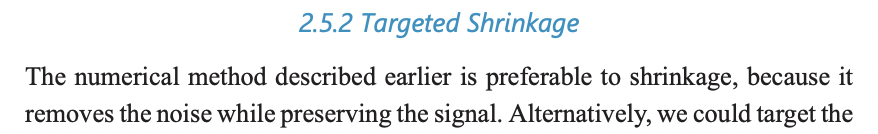

In [108]:
Image(filename='8.png',width=600, height=600)

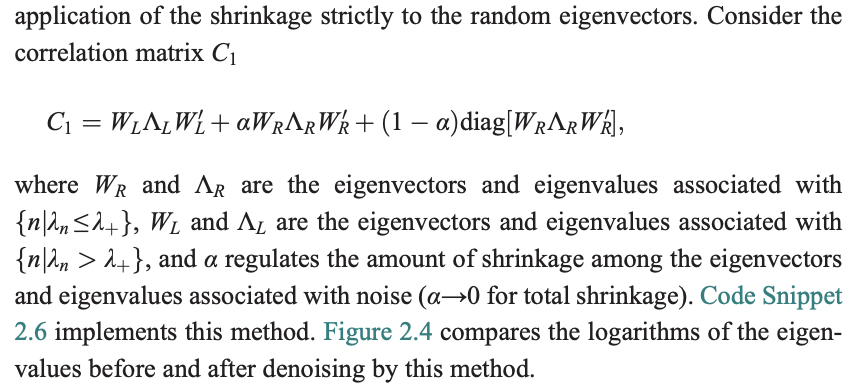

In [109]:
Image(filename='9.png',width=600, height=600)

In [58]:
# SNIPPET 2.6 DENOISING BY TARGETED SHRINKAGE
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
    # Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2
#--------------------------------------------------- 
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5) 
eVal1,eVec1=getPCA(corr1)

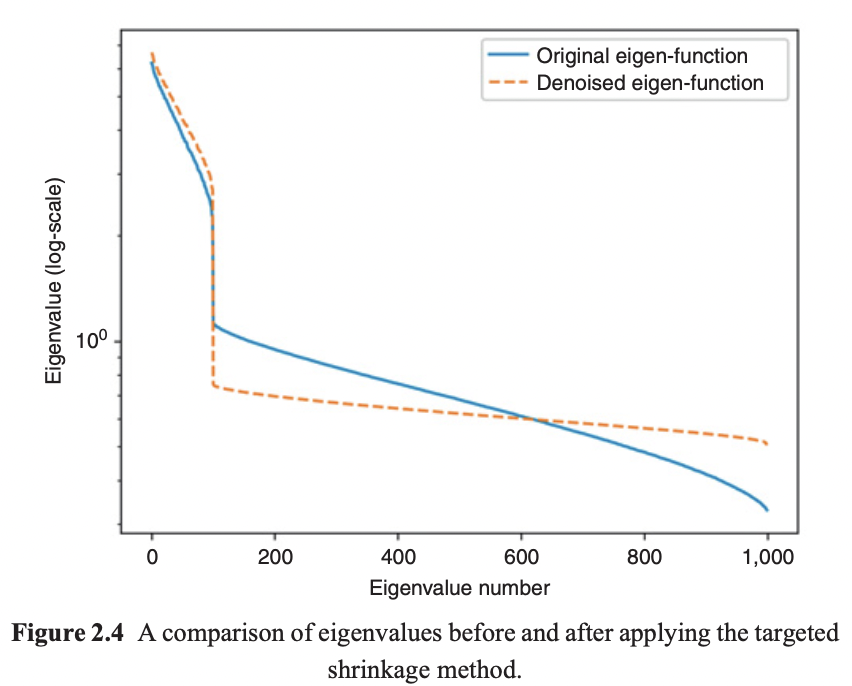

In [110]:
Image(filename='10.png',width=600, height=600)

# Ledoit - Wolf linear shrinkage

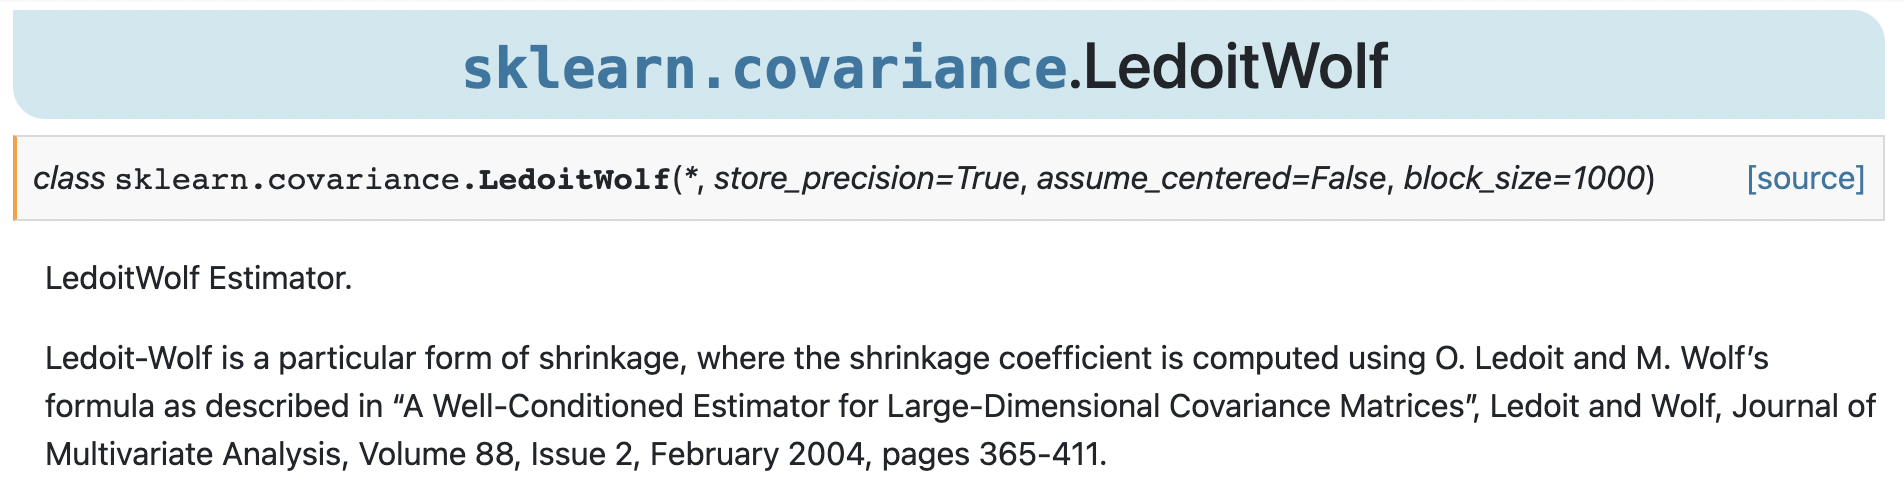

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.covariance.LedoitWolf.html
Image(filename='11.png',width=800, height=600)

# Minimum Variance Portfolio

In [63]:
# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#--------------------------------------------------- 
def deNoiseCov(cov0, q, bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0), q, bWidth) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0, eVec0, nFacts0)
    cov1=corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

In [64]:
# GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#--------------------------------------------------- 
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0, cov0
#--------------------------------------------------- 
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf 
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [68]:
# GENERATING THE EMPIRICAL COVARIANCE MATRIX
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:
        cov1=LedoitWolf().fit(x).covariance_ 
    else: 
        cov1=np.cov(x,rowvar=0)
    return mu1,cov1

In [76]:
# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None: mu=ones
    w=np.dot(inv,mu) 
    w/=np.dot(ones.T,w)
    return w

#--------------------------------------------------- 
nObs,nTrials,bWidth,shrink,minVarPortf=10, 10, .01, False, True 
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

In [77]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0) 
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE 
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE 
print(rmsd, rmsd_d)

0.1425729411487091 0.09691196878825092
